## Import and Load Data

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = pd.read_csv("../../data/ethusd_group_project.csv",parse_dates=['time'], index_col='time')
data = data.dropna()

## Data cleaning
### Features engineering

Now we will also take note of the weekly and daily rv

In [10]:
daily_rv = data['realized_variance']
weekly_rv = daily_rv.resample('W').mean()
monthly_rv = daily_rv.resample('ME').mean()

Make it log RV

In [11]:
log_daily_rv = np.log(daily_rv)
log_weekly_rv = np.log(weekly_rv)
log_monthly_rv = np.log(monthly_rv)

### Train-test split
We are mindful that the data is a time series data, so we will not randomise the data for the train test split. We will run a 80/20 split instead. 

In [ ]:
total_obs = len(data)
train_size = int(0.8 * total_obs)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

weekly_shifted = log_weekly_rv.shift(1).reindex(train_data.index, method='ffill')
monthly_shifted = log_monthly_rv.shift(1).reindex(train_data.index, method='ffill')

# Create the training features
X_train = pd.DataFrame({
    'ln_RV_d_t_minus_1': log_daily_rv.shift(1).loc[train_data.index],
    'ln_RV_w_t_minus_1': weekly_shifted,
    'ln_RV_m_t_minus_1': monthly_shifted,
    'open': data['open'].loc[train_data.index],
    'close': data['close'].loc[train_data.index],
    'high': data['high'].loc[train_data.index],
    'low': data['low'].loc[train_data.index],
    'volume': data['volume'].loc[train_data.index],
    'daily_return': data['daily_return'].loc[train_data.index]
})
y_train = log_daily_rv.loc[train_data.index]

# Drop any rows with NaN values
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]



## Random Forest
We will use a RF model to predict the realised variance

### Training the RF model

In [14]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

if X_train.shape[0] == y_train.shape[0]:
    rf_model.fit(X_train, y_train)
else:
    raise ValueError("Error: Inconsistent number of samples. Cannot train the model.")


Creating a one-day-ahead forecast

In [7]:
ln_rv_forecast = rf_model.predict(X_train.iloc[[-1]])[0]

### Updating the training sample
This is done by removing the oldest one and adding the latest one

### Out of sample performance
Now repeat the above mentioned steps from 2019 to 2023. This part will be the OOS section, and will be used to evaluate the model's performance.

Do note that our OOS begins in 2019.

In [ ]:
forecasts = []

# Use the test_data's index as the forecasting dates
test_dates = test_data.index

# Initialize the first forecast using the last observation in the training set
ln_rv_forecast = rf_model.predict(X_train.iloc[[-1]])[0]

window_size = X_train.shape[0]

# Loop through each date in the test period
for date in test_dates:
    # Construct the new observation for the current forecast date
    new_observation = pd.DataFrame({
        'ln_RV_d_t_minus_1': [ln_rv_forecast],
        'ln_RV_w_t_minus_1': [log_weekly_rv.asof(date)],
        'ln_RV_m_t_minus_1': [log_monthly_rv.asof(date)],
        'open': [data['open'].asof(date)],
        'close': [data['close'].asof(date)],
        'high': [data['high'].asof(date)],
        'low': [data['low'].asof(date)],
        'volume': [data['volume'].asof(date)],
        'daily_return': [data['daily_return'].asof(date)]
    }, index=[date])
    
    # Append the new observation to the training set
    X_train = pd.concat([X_train, new_observation])
    
    # If maintaining a fixed window, drop the oldest observation once window size exceeds
    if len(X_train) > window_size:
        X_train = X_train.iloc[-window_size:]
    
    # Re-align the index
    y_train = log_daily_rv.loc[X_train.index]
    y_train.dropna(inplace=True)
    X_train = X_train.loc[y_train.index]
    
    # Retrain the model with the updated window
    if X_train.shape[0] == y_train.shape[0]:
        rf_model.fit(X_train, y_train)
    else:
        raise ValueError("Error: Inconsistent number of samples. Cannot re-train the model.")
    
    # Generate the forecast for the current date
    ln_rv_forecast = rf_model.predict(new_observation)[0]
    rv_forecast = np.exp(ln_rv_forecast)  # Convert back from log-scale
    
    # Store the forecast
    forecasts.append(rv_forecast)


#### RMSFE
We will use RMSFE to evaluate the results

In [16]:
forecast_dates = test_data.index
forecasts_series = pd.Series(forecasts, index=forecast_dates)
actual_rv = data['realized_variance'].loc[forecast_dates]

errors = forecasts_series - actual_rv
rmsfe = np.sqrt(np.mean(errors ** 2))
print("RMSFE:", rmsfe)


RMSFE: 0.0008861757042852385


#### Feature Importance
We examined the feature importance of the RF model. We can note that the one day realised variance lag seems to be the most significant, followed by volume and then daily returns.

In [17]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (impurity based):")
print(feature_importance_df)



Feature Importances (impurity based):
             Feature  Importance
0  ln_RV_d_t_minus_1    0.526134
7             volume    0.254622
8       daily_return    0.113265
1  ln_RV_w_t_minus_1    0.028438
5               high    0.019993
2  ln_RV_m_t_minus_1    0.017270
3               open    0.015246
4              close    0.013185
6                low    0.011846


#### Plotting out
We will now plot out a line graph of data. 

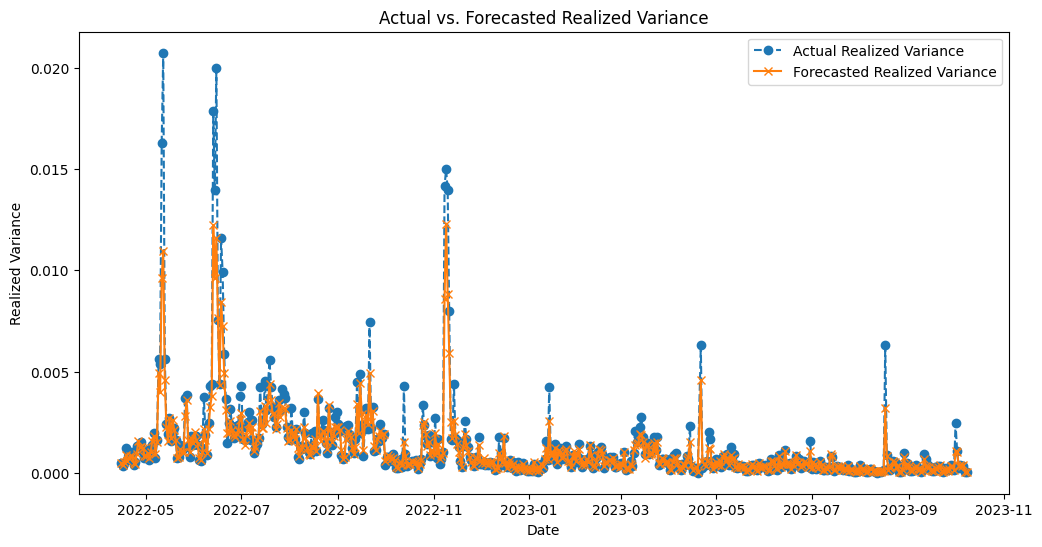

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(actual_rv.index, actual_rv, label="Actual Realized Variance", marker='o', linestyle='--')
plt.plot(forecasts_series.index, forecasts_series, label="Forecasted Realized Variance", marker='x', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("Actual vs. Forecasted Realized Variance")
plt.legend()
plt.show()

## HAR
Heterogenous Autoregression (HAR) is a form of autoregression that uses past data to predict the future data. 

We will use the same train test split above

### Reindexing daily and monthly rv

In [19]:
log_weekly_rv_daily = log_weekly_rv.reindex(daily_rv.index, method='ffill')
log_monthly_rv_daily = log_monthly_rv.reindex(daily_rv.index, method='ffill')


In [20]:
har_df = pd.DataFrame({
    'log_rv': log_daily_rv,
    'lag1_log_rv': log_daily_rv.shift(1),
    'lag_weekly': log_weekly_rv_daily.shift(1),
    'lag_monthly': log_monthly_rv_daily.shift(1)
})

# Drop initial missing observations
har_df = har_df.dropna()


### Train test split
We will still be using 80/20

In [28]:
train_df = har_df.iloc[:train_size]
test_df = har_df.iloc[train_size:]

### Training the model

In [23]:
X_train = train_df[['lag1_log_rv', 'lag_weekly', 'lag_monthly']]
y_train = train_df['log_rv']
X_train_const = sm.add_constant(X_train)

# Fit the model
har_model = sm.OLS(y_train, X_train_const).fit()
print(har_model.summary())


                            OLS Regression Results                            
Dep. Variable:                 log_rv   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     1065.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:17:20   Log-Likelihood:                -2084.2
No. Observations:                2118   AIC:                             4176.
Df Residuals:                    2114   BIC:                             4199.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7305      0.122     -6.011      

### Out of sample performance
Same as RF, we will run a one step ahead OOS forecasting for the trest data

In [25]:
forecasts = []  # to store forecasted log realized variance values

# For the first forecast, use the last observation from the training set:
last_train = train_df.iloc[-1]
prev_forecast = last_train['log_rv'] 

# We'll forecast for each date in the test set:
for date in test_df.index:
    lag1 = prev_forecast
    lag_weekly = log_weekly_rv_daily.loc[date]
    lag_monthly = log_monthly_rv_daily.loc[date]
    
    # Create a DataFrame with a constant term and the current features:
    X_new = pd.DataFrame({
        'const': [1],
        'lag1_log_rv': [lag1],
        'lag_weekly': [lag_weekly],
        'lag_monthly': [lag_monthly]
    })
    
    # Forecast log realized variance:
    forecast_log_rv = har_model.predict(X_new)[0]
    forecasts.append(forecast_log_rv)
    prev_forecast = forecast_log_rv
    
    # Convert forecasts from log scale back to the original variance scale:
forecasts_exp = np.exp(forecasts)

# Also convert the actual log values in the test set back to variance scale:
actual_exp = np.exp(test_df['log_rv'])



#### RMSFE

In [26]:
errors = forecasts_exp - actual_exp
rmsfe = np.sqrt(np.mean(errors**2))
print("HAR Model RMSFE:", rmsfe)


HAR Model RMSFE: 0.0021953792289417526


#### Plot of HAR


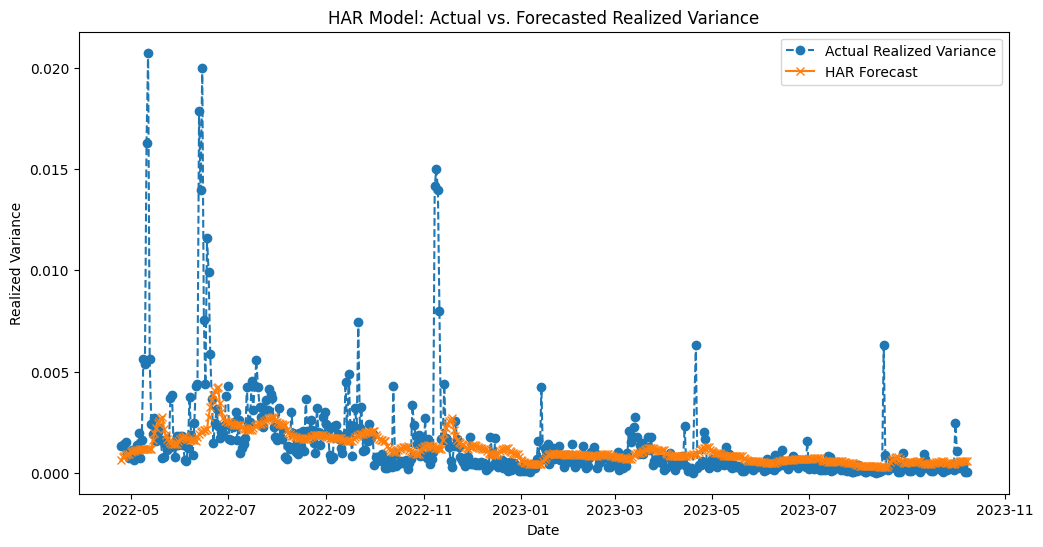

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, actual_exp, label="Actual Realized Variance", marker='o', linestyle='--')
plt.plot(test_df.index, forecasts_exp, label="HAR Forecast", marker='x', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("HAR Model: Actual vs. Forecasted Realized Variance")
plt.legend()
plt.show()
